In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from SingleGazeAnalysis import MetaAnalysis
from gazeheatplot import gaussian
from GazeStimuliImage import re_generate_stimuli as regesti
from preattentive_object import PreattentiveObject as preobj
from PersonalTraitGaze import draw_heatmap


this_preobj = preobj(1920,1080,'black')
task = 'task1'
path = os.path.join('ml-results','medium',f'RF_{task}_CM_meta.json')
with open(path, 'r') as f:
    data = json.load(f)

In [2]:
def visualize_cm(cm, name:str, path=None, title='Randomforest'):
    length_cm = cm.shape[0]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(list(range(1,length_cm+1))))
    disp.plot(include_values=False)
    disp.ax_.get_images()[0].set_clim(0,0.7)
    plt.title(f'{title}_{name}')
    # plt.show()
    if path:
        # print('wow')
        plt.savefig(os.path.join(path,f'{title}_confusion_matrix_{name}.png'))
        plt.close()

def normalize_cm(cm: np.array):
    new_cm = np.zeros_like(cm)
    cm_sum_list = cm.sum(axis=1)
    for i in range(13):
        for j in range(13):
            new_cm[i,j] = cm[i,j]/cm_sum_list[i]
    return new_cm



In [3]:
shape_cm = np.zeros((13,13), dtype=np.float64)
orientation_cm = np.zeros((13,13), dtype=np.float64)
size_cm = np.zeros((13,13), dtype=np.float64)
hue_cm = np.zeros((13,13), dtype=np.float64)
brightness_cm = np.zeros((13,13), dtype=np.float64)

for i in range(13):
    for j in range(13):
        this_data = data[f"true_{i+1}"][f"pred_{j+1}"]
        for k in this_data:
            hit, meta = k
            if meta['task'] == 'shape':
                shape_cm[i,j] += 1
            elif meta['task'] == 'size':
                size_cm[i,j] += 1
            elif meta['task'] == 'brightness':
                brightness_cm[i,j] += 1
            elif meta['task'] == 'hue':
                hue_cm[i,j] += 1
            elif meta['task'] == 'orientation':
                orientation_cm[i,j] += 1


shape_cm = normalize_cm(shape_cm)
size_cm = normalize_cm(size_cm)
brightness_cm = normalize_cm(brightness_cm)
hue_cm = normalize_cm(hue_cm)
orientation_cm = normalize_cm(orientation_cm)


visualize_cm(shape_cm, 'shape', title=task, path='ml-results/medium/task_cm')
visualize_cm(size_cm, 'size', title=task, path='ml-results/medium/task_cm')
visualize_cm(brightness_cm, 'brightenss', title=task, path='ml-results/medium/task_cm')
visualize_cm(hue_cm, 'hue', title=task, path='ml-results/medium/task_cm')
visualize_cm(orientation_cm, 'orientation', title=task, path='ml-results/medium/task_cm')

In [169]:
def draw_histogram(metaData, true=None, pred=None):
    if not (true and pred):
        meta_list = metaData
    else:
        meta_list = metaData[true][pred]
    difference = [0,0,0,0]
    target_shape = [0,0,0,0,0,0]
    distractor_shape = [0,0,0,0,0,0]
    set_size = [0,0,0]
    cnt_xy = []
    target_size = [0,0,0,0,0]
    distractor_size = [0,0,0,0,0]
    target_hue_r = []
    target_hue_g = []
    target_hue_b = []
    distractor_hue_r = []
    distractor_hue_g = []
    distractor_hue_b = []
    target_brightness = []
    distractor_brightness = []
    target_orientation = [0,0,0,0,0,0]
    distractor_orientation = [0,0,0,0,0,0]

    for meta in meta_list:
        this_meta = MetaAnalysis(meta)
        difference[similarity_encoding(this_meta.get_level())-1]+=1
        cnt = list(map(int, meta['target_cnt']))
        cnt.append(1)
        target_shape[encoding_task('shape', meta['shape_target'])-1]+=1
        distractor_shape[encoding_task('shape', meta['shape_distractor'])-1]+=1
        set_size[meta['set_size']-4]+=1
        cnt_xy.append(cnt)
        target_size[encoding_task('size', meta['target_size'])-1]+=1
        distractor_size[encoding_task('size', meta['distractor_size'])-1]+=1    
        target_hue_b.append(meta['target_color'][0])
        target_hue_g.append(meta['target_color'][1])
        target_hue_r.append(meta['target_color'][2])
        distractor_hue_b.append(meta['distractor_color'][0])
        distractor_hue_g.append(meta['distractor_color'][1])
        distractor_hue_r.append(meta['distractor_color'][2])
        target_brightness.append(encoding_task('brightness', meta['target_color']))
        distractor_brightness.append(encoding_task('brightness', meta['distractor_color']))
        target_orientation[encoding_task('orientation', meta['target_orientation'])-1]+=1
        distractor_orientation[encoding_task('orientation', meta['distractor_orientation'])-1]+=1

    bg = np.zeros((1080,1920))
    cnt_heatmap = draw_heatmap(cnt_xy, bg)
    plt.imshow(cnt_heatmap, cmap='jet')
    plt.title(f'Centroid {pred}@{true}')
    plt.show()
    # plt.close()
    plt.bar(list(range(6)),target_shape)
    plt.title(f'Target Shape {pred}@{true}')
    plt.show()

    plt.bar(list(range(6)),distractor_shape)
    plt.title(f'Distractor Shape {pred}@{true}')
    plt.show()

    plt.bar(list(range(3)),set_size)
    plt.title(f'Set Size {pred}@{true}')
    plt.show()

    plt.bar(list(range(5)),target_size)
    plt.title(f'Target Size {pred}@{true}')
    plt.show()

    plt.bar(list(range(5)),distractor_size)
    plt.title(f'Distractor Size {pred}@{true}')
    plt.show()

    plt.bar(list(range(6)),target_orientation)
    plt.title(f'Target Orientation {pred}@{true}')
    plt.show()

    plt.bar(list(range(6)),distractor_orientation)
    plt.title(f'Distractor Orientation {pred}@{true}')
    plt.show()

def similarity_encoding(similarity):
    if '#' in similarity:
        similarity = similarity.split('#')[1]
    similarity = list(map(int,similarity.split('-')))
    difference = abs(similarity[0]-similarity[1])
    return difference

def encoding_task(task, data):
    if task == 'shape':
        if data == 'orientation':
            return 6
        else:
            return data

    elif task == 'size':
        level_mapping = {30:1, 40:2, 50:3, 60:4, 70:5}
        return level_mapping[data]

    elif task == 'hue':
        return data

    elif task == 'brightness':
        return max(data)

    elif task == 'orientation':
        level_mapping = {-30:1, -15:2, 0:3, 15:4, 30:5, None:6}
        return level_mapping[data]



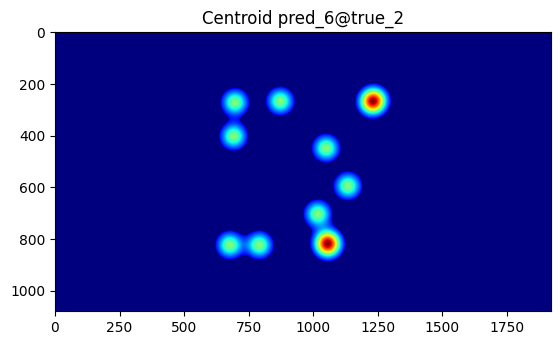

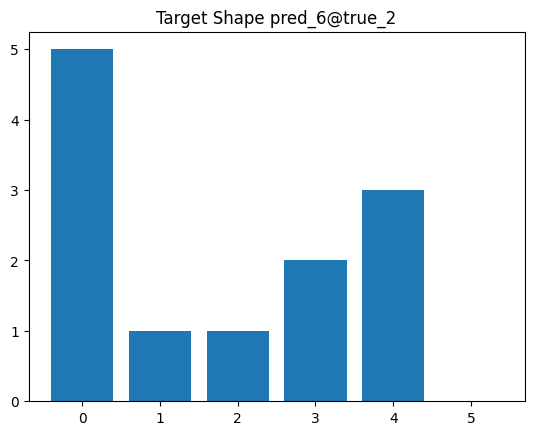

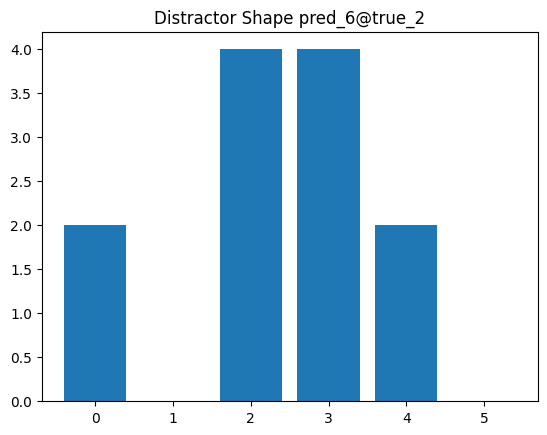

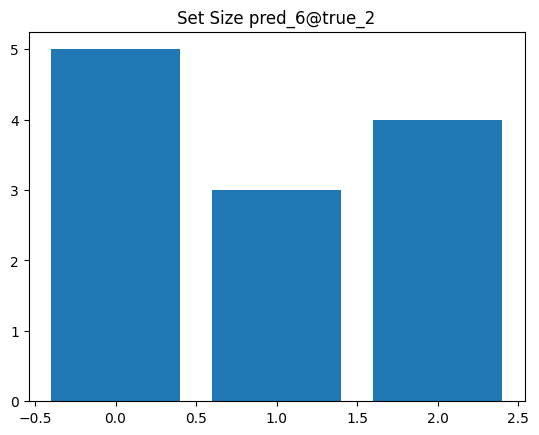

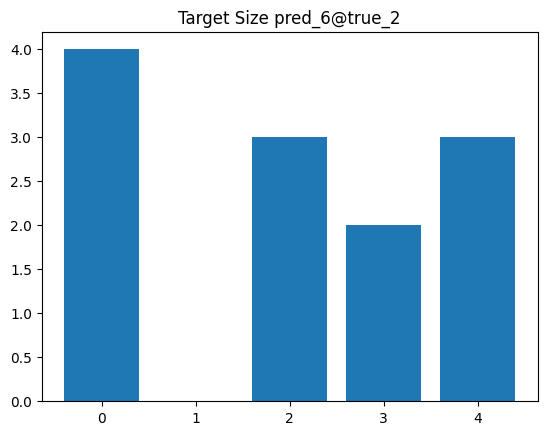

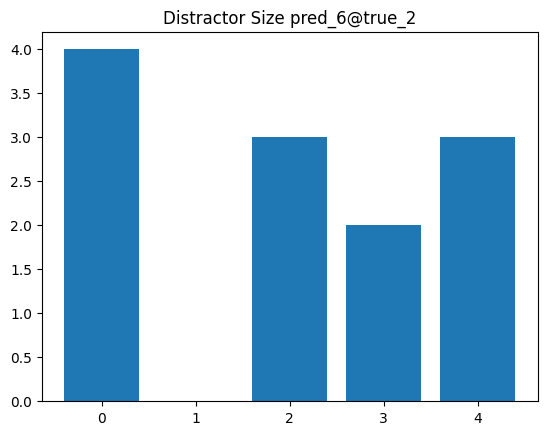

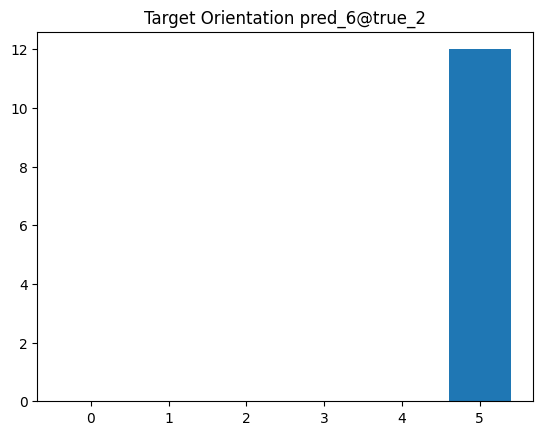

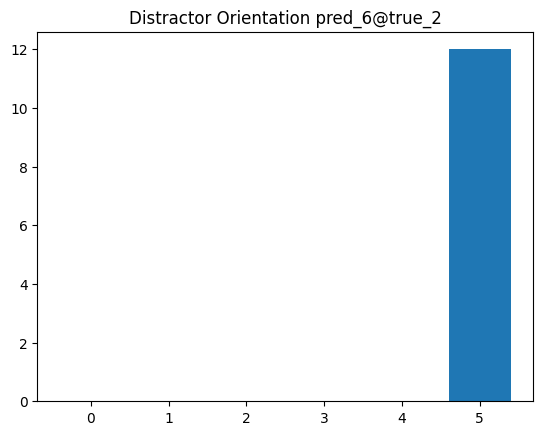

In [178]:
shape_meta = {f"true_{i}":{f"pred_{j}":[] for j in range(1,14)} for i in range(1,14)}
size_meta = {f"true_{i}":{f"pred_{j}":[] for j in range(1,14)} for i in range(1,14)}
brightness_meta = {f"true_{i}":{f"pred_{j}":[] for j in range(1,14)} for i in range(1,14)}
hue_meta = {f"true_{i}":{f"pred_{j}":[] for j in range(1,14)} for i in range(1,14)}
orientation_meta = {f"true_{i}":{f"pred_{j}":[] for j in range(1,14)} for i in range(1,14)}

for i in range(13):
    for j in range(13):
        this_data = data[f"true_{i+1}"][f"pred_{j+1}"]
        for k in this_data:
            hit, meta = k
            if meta['task'] == 'shape':
                shape_meta[f"true_{i+1}"][f"pred_{j+1}"].append(meta)
            elif meta['task'] == 'size':
                size_meta[f"true_{i+1}"][f"pred_{j+1}"].append(meta)
            elif meta['task'] == 'brightness':
                brightness_meta[f"true_{i+1}"][f"pred_{j+1}"].append(meta)
            elif meta['task'] == 'hue':
                hue_meta[f"true_{i+1}"][f"pred_{j+1}"].append(meta)
            elif meta['task'] == 'orientation':
                orientation_meta[f"true_{i+1}"][f"pred_{j+1}"].append(meta)
                

draw_histogram(shape_meta,'true_2','pred_6')


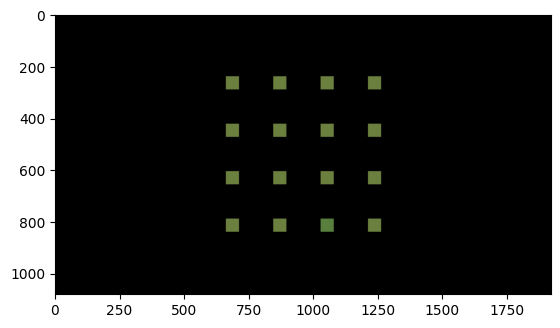

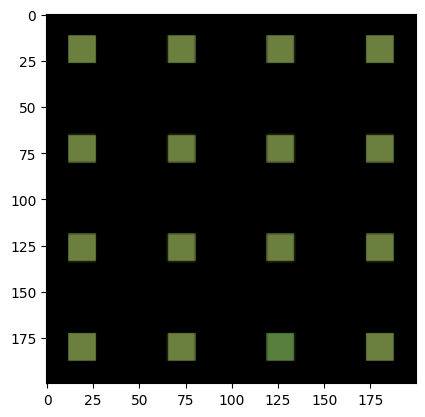

In [29]:
total_data = []
for i in range(13):
    if not i == 1:
        continue
    for j in range(13):
        this_data = data[f"true_{i+1}"][f"pred_{j+1}"]
        for k in this_data:
            hit, meta = k
            total_data.append(meta)
# print(total_data[0])
# draw_histogram(total_data)
img = regesti(this_preobj,total_data[7])
plt.imshow(img)
plt.show()
img = img[200:880,620:1300]
img = cv2.resize(img, (200,200))
plt.imshow(img)
plt.show()

In [13]:
cm_identify_dict = {'shape':shape_cm, 'size':size_cm, 'hue':hue_cm, 'brightness':brightness_cm, 'orientation':orientation_cm}
jspirit_dict = {}
for i in range(13):
    this_dict = {}
    for cm in cm_identify_dict:
        this_dict[cm] = cm_identify_dict[cm][i,i]
    jspirit_dict[i] = this_dict

jspirit_sorted_dict = {}
for i in jspirit_dict:
    jspirit_sorted_dict[i] = dict(sorted(jspirit_dict[i].items(), key=lambda item: item[1], reverse=True))

for i in jspirit_sorted_dict:
    print(f"{i+1}번 participant")
    print(jspirit_sorted_dict[i].keys())

1번 participant
dict_keys(['brightness', 'hue', 'orientation', 'size', 'shape'])
2번 participant
dict_keys(['hue', 'orientation', 'shape', 'size', 'brightness'])
3번 participant
dict_keys(['orientation', 'size', 'brightness', 'hue', 'shape'])
4번 participant
dict_keys(['hue', 'brightness', 'orientation', 'size', 'shape'])
5번 participant
dict_keys(['hue', 'brightness', 'orientation', 'shape', 'size'])
6번 participant
dict_keys(['shape', 'size', 'brightness', 'orientation', 'hue'])
7번 participant
dict_keys(['brightness', 'size', 'hue', 'shape', 'orientation'])
8번 participant
dict_keys(['orientation', 'hue', 'shape', 'brightness', 'size'])
9번 participant
dict_keys(['size', 'hue', 'orientation', 'shape', 'brightness'])
10번 participant
dict_keys(['brightness', 'size', 'shape', 'hue', 'orientation'])
11번 participant
dict_keys(['orientation', 'shape', 'hue', 'size', 'brightness'])
12번 participant
dict_keys(['orientation', 'shape', 'size', 'brightness', 'hue'])
13번 participant
dict_keys(['orientati

In [185]:
# with open(os.path.join('ml-results','medium','task_cm',f'{task}_shape.npy'), 'wb') as f:
#     np.save(f, shape_cm)
# with open(os.path.join('ml-results','medium','task_cm',f'{task}_size.npy'), 'wb') as f:
#     np.save(f, size_cm)
# with open(os.path.join('ml-results','medium','task_cm',f'{task}_hue.npy'), 'wb') as f:
#     np.save(f, hue_cm)
# with open(os.path.join('ml-results','medium','task_cm',f'{task}_brightness.npy'), 'wb') as f:
#     np.save(f, brightness_cm)
# with open(os.path.join('ml-results','medium','task_cm',f'{task}_orientation.npy'), 'wb') as f:
#     np.save(f, orientation_cm)

In [187]:
# print(shape_cm.sum(axis=1))

# with open(f"ml-results/medium/RF_{task}_shape_CM_meta.json", "w") as f:
#     json.dump(shape_meta, f, default=str)
# with open(f"ml-results/medium/RF_{task}_size_CM_meta.json", "w") as f:
#     json.dump(size_meta, f, default=str)
# with open(f"ml-results/medium/RF_{task}_brightness_CM_meta.json", "w") as f:
#     json.dump(brightness_meta, f, default=str)
# with open(f"ml-results/medium/RF_{task}_hue_CM_meta.json", "w") as f:
#     json.dump(hue_meta, f, default=str)
# with open(f"ml-results/medium/RF_{task}_orientation_CM_meta.json", "w") as f:
#     json.dump(orientation_meta, f, default=str)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
